In [1]:

import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqldf

import time 

import tqdm
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
#from skopt.space import Real, Categorical, Integer
#from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

import researchpy as rp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms


In [2]:
### calculating the distance 
def calculate_distance_haversine(lat1, lon1, lat2, lon2):
    # radius of earth
    from math import radians, cos, sin, asin, sqrt
    r = 3962.173405788

    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = [radians(x) for x in [lat1, lon1, lat2, lon2]]
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return r * c


def mapTransType(x):
    
    if x["IscreatorFoodWasteHero"] == 1 and x["FWH_collector"] == 1:
        return "A"
    elif x["IscreatorFoodWasteHero"] == 1 and x["FWH_collector"] == 0:
        return "B"
    else:
        return "C"

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time 
import pickle

### distance function
# Calculates distance using Haversine formula
def calculate_distance_haversine(lat1, lon1, lat2, lon2):
    # radius of earth
    from math import radians, cos, sin, asin, sqrt
    r = 3962.173405788

    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = [radians(x) for x in [lat1, lon1, lat2, lon2]]
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return r * c


def getAddress(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("display_name",0)
    except TypeError:
        return "LocationNotFound"
    
def getBorough(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'

    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("city_state",0)
    except TypeError:
        return "LocationNotFound"
    
    
def getCity(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("city",0)
    except TypeError:
        return "LocationNotFound"

def getPostcode(lat,long):

    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'    

    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("postcode",0)
    except TypeError:
        return "LocationNotFound"


def getInfo(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    location = locator.reverse(coordinate)
    if location != None:
        return location.raw
    else:
        return "LocationNotFound"
    


In [3]:
### reproduce london transaction from original dataset

## load original dataset
articles = pd.read_csv("articles_clean_0108.csv",error_bad_lines=False,encoding='ISO-8859-1')
article_pickups = pd.read_csv("article_pickups.csv")
article_transitions = pd.read_csv("article_transitions.csv")

### process information to desirable format

articles["created_at"] = pd.to_datetime(articles["created_at"],format = "%d/%m/%y %H:%M")
articles["updated_at"] = pd.to_datetime(articles["updated_at"],format="%d/%m/%y %H:%M")


### first article picked up

article_pickups["created_at"] = pd.to_datetime(article_pickups["created_at"],format = "%d/%m/%y %H:%M")
article_pickups["updated_at"] = pd.to_datetime(article_pickups["updated_at"],format = "%d/%m/%y %H:%M")

article_pickup_left = articles.merge(article_pickups,right_on = "article_id", left_on="id",suffixes=["_article","_pickup"], how = "left")



/anaconda3/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def response(x,y):
    """
    x: status
    y: article_id
    """
   # print(str(x))
   # print(y)
    if (str(x) == "pickup_arranged") & (pd.notnull(y)):
        return 1
    else:
        return 0
        

In [5]:
## among all those pickup articles, how many articles are pickedup within a given t minutes
article_pickup_left["response"] = article_pickup_left[["status","article_id"]].apply(lambda x:response(x[0],x[1]),axis=1)

In [6]:
### time difference between pickup and created

article_pickup_left["time_diff_inHours"] = (article_pickup_left["created_at_pickup"] - article_pickup_left["created_at_article"]) / np.timedelta64(1,'s') / 3600

In [7]:
article_pickup_left.shape

(328751, 37)

In [8]:
### filter out those articles which do not miss values of lat and long

data = article_pickup_left[article_pickup_left["lat"].notnull() & 
                   article_pickup_left["long"].notnull()]

In [9]:
data["lat"] = data["lat"].astype(float)
data["long"] = data["long"].astype(float)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
### use python package to obtain geographic location

In [11]:
unique_article_loc = list(set(list(data[["lat","long"]].itertuples(index = False, name = None))))

In [12]:
len(unique_article_loc) 

57648

In [13]:
file_save = "IntermediateData/IntermediateArticleLocation/"

In [14]:
locator = Nominatim(user_agent='Geocoder')

In [15]:
print("The first part of location")
article_loc_dict1 = {}
for elem in unique_article_loc[:12500]:
    result = getInfo(elem[0],elem[1])
    article_loc_dict1[elem] = result
    
with open(file_save + 'article_loc_dict1.pickle', 'wb') as handle:
    pickle.dump(article_loc_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("The second part of location")
article_loc_dict2 = {}
for elem in unique_article_loc[12500:25000]:
    result = getInfo(elem[0],elem[1])
    article_loc_dict2[elem] = result
    
with open(file_save + 'article_loc_dict2.pickle', 'wb') as handle:
    pickle.dump(article_loc_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("The third part of location，10000，15000")
article_loc_dict3 = {}
for elem in unique_article_loc[25000:37500]:
    result = getInfo(elem[0],elem[1])
    article_loc_dict3[elem] = result
    
with open(file_save + 'article_loc_dict3.pickle', 'wb') as handle:
    pickle.dump(article_loc_dict3, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(unique_article_loc))
print("The fourth part of location")
article_loc_dict4 = {}

for i, elem in enumerate(unique_article_loc[37500:]):
    print(i)
    result = getInfo(elem[0], elem[1])
    article_loc_dict4[elem] = result

with open(file_save + 'article_loc_dict4.pickle', 'wb') as handle:
    pickle.dump(article_loc_dict4, handle, protocol=pickle.HIGHEST_PROTOCOL)
    




The first part of location
51.479,0.001
51.5,-0.013
41.368,2.135


KeyboardInterrupt: 

In [16]:
### load the article location information
with open('/Users/zhanghaonan/Desktop/MSIA/michigan/IntermediateData/IntermediateArticleLocation/article_loc_dict1.pickle', 'rb') as handle:
    article_loc_dict1 = pickle.load(handle)

with open('/Users/zhanghaonan/Desktop/MSIA/michigan/IntermediateData/IntermediateArticleLocation/article_loc_dict2.pickle', 'rb') as handle:
    article_loc_dict2 = pickle.load(handle)

with open('/Users/zhanghaonan/Desktop/MSIA/michigan/IntermediateData/IntermediateArticleLocation/article_loc_dict3.pickle', 'rb') as handle:
    article_loc_dict3 = pickle.load(handle)

with open('/Users/zhanghaonan/Desktop/MSIA/michigan/IntermediateData/IntermediateArticleLocation/article_loc_dict4.pickle', 'rb') as handle:
    article_loc_dict4 = pickle.load(handle)

In [17]:
article_merged = {
    **article_loc_dict1,
    **article_loc_dict2,
    **article_loc_dict3,
    **article_loc_dict4
}

In [18]:
#creator_merged

def address_map(x,mapper):
    '''
    x: geom lat and long
    '''
    
    if str(x) == 'nan':
        return 'nan'
    elif mapper.get(x) == 'LocationNotFound':
        return 'LocationNotFound'
    else:
        return mapper[x]["display_name"]

def mapper(x,mapper,granularity = "city"):
    '''
    x: geom lat and long
    granularity: 
    'city_district': 'London Borough of Bexley',
   'city': 'London',
   'state_district': 'Greater London',
   'state': 'England',
   'postcode': 'DA8 3DR',
   'country': 'United Kingdom',
    '''
    
    if str(x) == 'nan':
        return 'nan'
    elif mapper.get(x) == 'LocationNotFound':
        return 'LocationNotFound'
    else:
        return mapper[x].get("address","No Info").get(granularity,granularity + " NA")

In [19]:
data["article_geom"] = data.apply(lambda x:(x['lat'],x["long"])
                                            if (str(x['lat'])!= 'nan') & (str(x['long'])!='nan') else 'nan',axis=1)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
### drop those without description, title and collection_notes
data_copy = data[(data["title"].notnull()) &
    (data["description"].notnull()) &
    (data["collection_notes"].notnull())]

In [21]:
diff = set(list(data_copy[['lat',"long"]].itertuples(index=False, name = None))) - set(list(article_merged.keys())) 

In [22]:
### 

len(set(list(article_merged.keys())))

57554

In [23]:
len(set(list(data_copy[['lat',"long"]].itertuples(index=False, name = None))) )

57631

In [24]:
len(diff)

3142

In [ ]:
#with open('additionalArticleLoc.pickle', 'wb') as handle:
 #   pickle.dump(diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('additionalArticleLoc.pickle', 'rb') as handle:
 #   b = pickle.load(handle)

In [ ]:
### generate additio
article_loc_dict1 = {}
for elem in list(b):
    result = getInfo(elem[0],elem[1])
    article_loc_dict1[elem] = result
    
with open(file_save + 'additional_article_loc0608.pickle', 'wb') as handle:
    pickle.dump(article_loc_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [30]:
### load the additional location information
with open(file_save + 'additional_article_loc0608.pickle', 'rb') as handle:
    article_loc_dict1 = pickle.load(handle)

In [31]:
article_merged = {**article_merged,**article_loc_dict1}

In [32]:
data_copy["article_city_district"] = data_copy["article_geom"].apply(lambda x: 
                                                 mapper(x,article_merged,'city_district'))
                                        

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
data_copy["article_city"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'city'))
                                                        
data_copy["article_state_district"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'state_district'))
                                                        
data_copy["article_state"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'state'))


data_copy["article_postcode"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'postcode'))
                                                        
data_copy["article_country"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'country')) 

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [34]:
data_copy["article_neighbourhood"] = data_copy["article_geom"].apply(lambda x: 
                                    mapper(x,article_merged,'neighbourhood')) 

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
data_copy["article_city_district_neighbourhood_concat"] = data_copy["article_city_district"] + " - " + data_copy["article_neighbourhood"]

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
city_district_article_count = data_copy.groupby(["article_country","article_state_district","article_city","article_city_district"],as_index=False)["id_article"].agg({"id_article": "nunique"})

In [37]:
city_district_article_count.sort_values(by = "id_article",ascending=False,inplace=True)

In [38]:
city_district_article_count.id_article.sum()

264491

In [39]:
data_copy.iloc[0]

id_article                                                                                1
title                                                          Two packets of green lentils
description                                         Having a cupboard clear out. 500g each.
lat                                                                                 51.5756
long                                                                              -0.123625
expiry                                                                        16/7/15 11:25
collection_notes                                      Anytime on Friday or over the weekend
user_id_article                                                                           2
created_at_article                                                      2015-07-09 11:25:00
updated_at_article                                                      2017-09-25 09:08:00
price                                                                           

In [40]:
city_district_article_count[city_district_article_count["article_country"] == "Jersey"]

,article_country,article_state_district,article_city,article_city_district,id_article
380,Jersey,state_district NA,city NA,city_district NA,47361
376,Jersey,state_district NA,Saint Saviour,city_district NA,133
377,Jersey,state_district NA,city NA,La Vingtaine de la Ville,42
375,Jersey,state_district NA,Saint Saviour,Vingtaine de Petite Longueville,22
378,Jersey,state_district NA,city NA,Vigntaine de Hérupe,11
373,Jersey,state_district NA,Saint Ouen,city_district NA,7
374,Jersey,state_district NA,Saint Saviour,Vigntaine de Maufant,4
379,Jersey,state_district NA,city NA,Vigntaine du Sud,1


In [41]:
city_district_article_count.loc[
    (city_district_article_count["article_country"] == "United Kingdom"),'id_article' 
].sum()

198884

There are 198884 articles in United Kingdom, and 122982 articles are in Greater London region. 

Among these 122982 articles, 106978 articles have a mapping of location at the ward level.

In [42]:
city_district_article_count.loc[
    (city_district_article_count["article_country"] == "United Kingdom") 
    & (city_district_article_count['article_state_district'] == "Greater London"),'id_article'
].sum()

122982

In [43]:
city_district_article_count.loc[
    (city_district_article_count["article_country"] == "United Kingdom") 
    & (city_district_article_count['article_state_district'] == "Greater London")
    & (city_district_article_count["article_city_district"]!= "city_district NA")
].sum()

article_country           United KingdomUnited KingdomUnited KingdomUnit...
article_state_district    Greater LondonGreater LondonGreater LondonGrea...
article_city              LondonLondonLondonLondonLondonLondonLondonLond...
article_city_district     London Borough of HaringeyLondon Borough of Is...
id_article                                                           106978
dtype: object

In [44]:
### decide the user location based on all articles they made in the past

In [45]:
data_copy.loc[(data_copy["article_country"] == "United Kingdom")
             & (data_copy["article_state_district"] == "Greater London")
             &(data_copy["article_city_district"] == "city_district NA")]
          

,id_article,title,description,lat,long,expiry,collection_notes,user_id_article,created_at_article,updated_at_article,...,time_diff_inHours,article_geom,article_city_district,article_city,article_state_district,article_state,article_postcode,article_country,article_neighbourhood,article_city_district_neighbourhood_concat
687,688,Peach and Apricot Yoghurt,"My daughter only likes the berry flavours, so ...",51.523617,-0.147500,25/9/15 17:28,Anytime,5181.0,2015-09-18 17:28:00,2017-09-25 09:08:00,...,NaN,"(51.523617, -0.1475)",city_district NA,City of Westminster,Greater London,England,NW1 5HD,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
735,736,Sweet Potato and 2 Red Onions (organic),Headed on holiday and have extra organic veg -...,51.523617,-0.147500,29/9/15 20:58,Anytime,5181.0,2015-09-22 20:58:00,2017-03-10 14:18:00,...,NaN,"(51.523617, -0.1475)",city_district NA,City of Westminster,Greater London,England,NW1 5HD,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
819,820,British extra thick double fresh cream,"The pot is new and sealed, to be eaten by the ...",51.534377,-0.056178,8/10/15 10:40,Evenings from 7,5493.0,2015-10-01 10:40:00,2017-03-10 14:18:00,...,NaN,"(51.534377, -0.056178)",city_district NA,London,Greater London,England,E2 9DR,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
821,822,Old el paso salsa,"One old el paso salsa pack. New, good until 04...",51.534309,-0.056963,29/10/15 19:53,I am away this weekend but from the 4th inthe ...,5654.0,2015-10-01 18:53:00,2017-09-25 09:08:00,...,NaN,"(51.534309, -0.056963)",city_district NA,London,Greater London,England,E2 9DR,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
888,889,WANTED: your pumpkins!,Any glut of edible pumpkins or squash for a se...,51.511989,-0.121639,5/11/15 22:36,"Weekday evenings, weekends",5699.0,2015-10-11 21:36:00,2017-09-25 09:08:00,...,NaN,"(51.511989, -0.12163900000000001)",city_district NA,City of Westminster,Greater London,England,WC2,United Kingdom,St Clement Danes,city_district NA - St Clement Danes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328661,264515,Pret food pick up before 4:30pm today,Meat lasagne plus some soups,51.494328,-0.144731,31/10/18 15:47,Today until 4:30pm,559817.0,2018-10-30 15:47:00,2018-10-30 16:23:00,...,0.516667,"(51.494328, -0.144731)",city_district NA,City of Westminster,Greater London,England,SW1W 9SJ,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
328662,264515,Pret food pick up before 4:30pm today,Meat lasagne plus some soups,51.494328,-0.144731,31/10/18 15:47,Today until 4:30pm,559817.0,2018-10-30 15:47:00,2018-10-30 16:23:00,...,0.533333,"(51.494328, -0.144731)",city_district NA,City of Westminster,Greater London,England,SW1W 9SJ,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
328663,264515,Pret food pick up before 4:30pm today,Meat lasagne plus some soups,51.494328,-0.144731,31/10/18 15:47,Today until 4:30pm,559817.0,2018-10-30 15:47:00,2018-10-30 16:23:00,...,0.583333,"(51.494328, -0.144731)",city_district NA,City of Westminster,Greater London,England,SW1W 9SJ,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
328731,264576,"Pret A Manger - sandwiches, baguettes, yogurts...",First come first serve starting at 7pm in 21 B...,51.515000,-0.070000,31/10/18 16:35,"Starting 7pm, first come first serve",369825.0,2018-10-30 16:35:00,2018-10-30 16:47:00,...,0.483333,"(51.515, -0.07)",city_district NA,London,Greater London,England,E1 7AT,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA


In [47]:
### filter london data based on the following logic, the state district is Greater London

data_london = data_copy.loc[(data_copy["article_country"] == "United Kingdom")
             & (data_copy["article_state_district"] == "Greater London")
             & (data_copy["article_city_district"] != "LocationNotFound")]
          

In [48]:
data_london.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153072 entries, 0 to 328743
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   id_article                                  153072 non-null  int64         
 1   title                                       153072 non-null  object        
 2   description                                 153072 non-null  object        
 3   lat                                         153072 non-null  float64       
 4   long                                        153072 non-null  float64       
 5   expiry                                      153072 non-null  object        
 6   collection_notes                            153072 non-null  object        
 7   user_id_article                             153067 non-null  float64       
 8   created_at_article                          153072 non-null  datetime64[ns

In [49]:
data_london["id_article"].nunique()

122982

In [50]:
### count the number of 

In [51]:
data_london.columns

Index(['id_article', 'title', 'description', 'lat', 'long', 'expiry',
       'collection_notes', 'user_id_article', 'created_at_article',
       'updated_at_article', 'price', 'deleted_at_article', 'dropbox_id',
       'currency', 'section', 'payment_type', 'status', 'multiple_pickup',
       'pickups_count', 'last_listed', 'conversations_count', 'first_request',
       'likes_count', 'first_article', 'collection_id', 'geohash',
       'veteran_delay', 'id_pickup', 'article_id', 'user_id_pickup',
       'created_at_pickup', 'updated_at_pickup', '{:index=>true}_id',
       'conversation_id', 'deleted_at_pickup', 'response', 'time_diff_inHours',
       'article_geom', 'article_city_district', 'article_city',
       'article_state_district', 'article_state', 'article_postcode',
       'article_country', 'article_neighbourhood',
       'article_city_district_neighbourhood_concat'],
      dtype='object')

In [52]:
data_london.rename(columns ={
    "id_article":"article_id",
    "lat": "article_lat",
    "long":"article_long",
    "user_id_article":"creator_id",
    "created_at_article": "article_created_at",
    "id_pickup":"pickup_id",
    "user_id_pickup":"receiver_id",
    "created_at_pickup":"pickup_created_at",
    "response":"pickup"
},inplace=True)

/anaconda3/envs/nlp/lib/python3.6/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [53]:
data_london.columns

Index(['article_id', 'title', 'description', 'article_lat', 'article_long',
       'expiry', 'collection_notes', 'creator_id', 'article_created_at',
       'updated_at_article', 'price', 'deleted_at_article', 'dropbox_id',
       'currency', 'section', 'payment_type', 'status', 'multiple_pickup',
       'pickups_count', 'last_listed', 'conversations_count', 'first_request',
       'likes_count', 'first_article', 'collection_id', 'geohash',
       'veteran_delay', 'pickup_id', 'article_id', 'receiver_id',
       'pickup_created_at', 'updated_at_pickup', '{:index=>true}_id',
       'conversation_id', 'deleted_at_pickup', 'pickup', 'time_diff_inHours',
       'article_geom', 'article_city_district', 'article_city',
       'article_state_district', 'article_state', 'article_postcode',
       'article_country', 'article_neighbourhood',
       'article_city_district_neighbourhood_concat'],
      dtype='object')

In [54]:
set(data_london["status"])

{'active', 'deleted', 'expired', 'inactive', 'pickup_arranged'}

In [55]:
data_london

,article_id,title,description,article_lat,article_long,expiry,collection_notes,creator_id,article_created_at,updated_at_article,...,time_diff_inHours,article_geom,article_city_district,article_city,article_state_district,article_state,article_postcode,article_country,article_neighbourhood,article_city_district_neighbourhood_concat
0,1,Two packets of green lentils,Having a cupboard clear out. 500g each.,51.575572,-0.123625,16/7/15 11:25,Anytime on Friday or over the weekend,2.0,2015-07-09 11:25:00,2017-09-25 09:08:00,...,NaN,"(51.575571999999994, -0.123625)",London Borough of Haringey,London,Greater London,England,N8 9QW,United Kingdom,Crouch Hall Park,London Borough of Haringey - Crouch Hall Park
1,2,All Bran 750g,Swapped my morning cereal for eggs so don't ne...,51.575662,-0.123365,16/7/15 11:45,"Friday onwards anytime, message me",2.0,2015-07-09 11:45:00,2017-03-10 14:18:00,...,NaN,"(51.575662, -0.123365)",London Borough of Haringey,London,Greater London,England,N8 9QX,United Kingdom,Crouch Hall Park,London Borough of Haringey - Crouch Hall Park
2,3,Half price Vadasz Deli pickles and relish,Best before relish 20/07 - £2.37\nBest before ...,51.583772,-0.100280,16/7/15 12:00,9am - 8pm,3.0,2015-07-09 12:00:00,2017-03-10 14:18:00,...,NaN,"(51.583771999999996, -0.10028)",London Borough of Haringey,London,Greater London,England,N8 0RL,United Kingdom,Duckett's Green,London Borough of Haringey - Duckett's Green
3,4,Goats cheese & sundries tomato burgers,Use by 09/07,51.583815,-0.100250,16/7/15 12:04,Today until 9pm,3.0,2015-07-09 12:04:00,2017-03-10 14:18:00,...,NaN,"(51.583815, -0.10025)",London Borough of Haringey,London,Greater London,England,N8 0RL,United Kingdom,Duckett's Green,London Borough of Haringey - Duckett's Green
4,5,Dijon Mustard - unopened,Jar has been in cupboard and expires 14.08.15 ...,51.573706,-0.127276,16/7/15 13:34,Weekday evenings preferably,7.0,2015-07-09 13:34:00,2017-09-25 09:08:00,...,NaN,"(51.573706, -0.127276)",London Borough of Haringey,London,Greater London,England,N8 9QQ,United Kingdom,Crouch Hall Park,London Borough of Haringey - Crouch Hall Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328731,264576,"Pret A Manger - sandwiches, baguettes, yogurts...",First come first serve starting at 7pm in 21 B...,51.515000,-0.070000,31/10/18 16:35,"Starting 7pm, first come first serve",369825.0,2018-10-30 16:35:00,2018-10-30 16:47:00,...,0.483333,"(51.515, -0.07)",city_district NA,London,Greater London,England,E1 7AT,United Kingdom,neighbourhood NA,city_district NA - neighbourhood NA
328733,264578,5 x Cherry Coca-Cola cans,cherry coca-cola cans,51.555000,0.007580,4/11/18 16:35,Anytime this evening,717471.0,2018-10-30 16:35:00,2018-10-30 16:35:00,...,NaN,"(51.555, 0.00758)",London Borough of Waltham Forest,London,Greater London,England,E11 3JH,United Kingdom,neighbourhood NA,London Borough of Waltham Forest - neighbourho...
328736,264581,Rock candy pack,Iranian rock candy pack,51.555000,0.008000,4/11/18 16:37,Anytime this evening,717471.0,2018-10-30 16:37:00,2018-10-30 16:37:00,...,NaN,"(51.555, 0.008)",London Borough of Waltham Forest,London,Greater London,England,E11 3JH,United Kingdom,neighbourhood NA,London Borough of Waltham Forest - neighbourho...
328738,264583,Japanese golden curry sauce mix,"5 servings, unopened, expiry is 17/12/2019",51.497200,-0.192330,4/11/18 16:39,"Most times from 6-11pm, message to arrange time",540230.0,2018-10-30 16:39:00,2018-10-30 16:39:00,...,NaN,"(51.4972, -0.19233)",Royal Borough of Kensington and Chelsea,London,Greater London,England,W8 5UA,United Kingdom,neighbourhood NA,Royal Borough of Kensington and Chelsea - neig...


In [56]:
data_london.loc[:,['article_id', 'creator_id', 'receiver_id','pickup_id','pickup',
                   'article_created_at','pickup_created_at','article_lat', 'article_long',
                   'title', 'description', 'collection_notes', 'status', 'collection_id', 'time_diff_inHours',
       'article_geom', 'article_city_district', 'article_city',
       'article_state_district', 'article_state', 'article_postcode',
       'article_country', 'article_neighbourhood',
       'article_city_district_neighbourhood_concat']].to_csv("IntermediateData/london_transaction0618.csv")

In [61]:
data_london.loc[:,[
    "article_id"
]]

,article_id,article_id
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
...,...,...
328731,264576,264576.0
328733,264578,NaN
328736,264581,NaN
328738,264583,NaN


In [57]:
### then I will run Location.py script to get the location cluster for each creator and receiver

len(set(data_london.creator_id))

11458

In [58]:
### 0615 Data Processing - location
london_transaction = pd.read_csv("IntermediateData/london_transaction0618.csv")

In [65]:
london_transaction.drop(["Unnamed: 0","article_id.1"],axis=1,inplace=True)

In [66]:
london_transaction.columns

Index(['article_id', 'creator_id', 'receiver_id', 'pickup_id', 'pickup',
       'article_created_at', 'pickup_created_at', 'article_lat',
       'article_long', 'title', 'description', 'collection_notes', 'status',
       'collection_id', 'time_diff_inHours', 'article_geom',
       'article_city_district', 'article_city', 'article_state_district',
       'article_state', 'article_postcode', 'article_country',
       'article_neighbourhood', 'article_city_district_neighbourhood_concat'],
      dtype='object')

In [67]:
### get creator's location and receiver location

with open('IntermediateData/IntermediateCreatorLocation/LocationCluster10609.pickle', 'rb') as handle:
    LocationCluster1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/LocationCluster20609.pickle', 'rb') as handle:
    LocationCluster2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/LocationCluster30609.pickle', 'rb') as handle:
    LocationCluster3 = pickle.load(handle)

with open('IntermediateData/IntermediateCreatorLocation/LocationCluster40609.pickle', 'rb') as handle:
    LocationCluster4 = pickle.load(handle)

In [68]:

with open('IntermediateData/IntermediateCreatorLocation/LocationCheck10609.pickle', 'rb') as handle:
    LocationCheck1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/LocationCheck20609.pickle', 'rb') as handle:
    LocationCheck2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/LocationCheck30609.pickle', 'rb') as handle:
    LocationCheck3 = pickle.load(handle)

with open('IntermediateData/IntermediateCreatorLocation/LocationCheck40609.pickle', 'rb') as handle:
    LocationCheck4 = pickle.load(handle)

In [69]:
## receiver
with open('IntermediateData/IntermediateReceiverLocation/LocationReceiverCluster10609_5mile.pickle', 'rb') as handle:
    LocationReceiverCluster1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/LocationReceiverCluster20609_5mile.pickle', 'rb') as handle:
    LocationReceiverCluster2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/LocationReceiverCluster30609_5mile.pickle', 'rb') as handle:
    LocationReceiverCluster3 = pickle.load(handle)

with open('IntermediateData/IntermediateReceiverLocation/LocationReceiverCluster40609_5mile.pickle', 'rb') as handle:
    LocationReceiverCluster4 = pickle.load(handle)

In [70]:
with open('IntermediateData/IntermediateReceiverLocation/LocationCheckReceiver10609.pickle', 'rb') as handle:
    LocationReceiverCheck1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/LocationCheckReceiver20609.pickle', 'rb') as handle:
    LocationReceiverCheck2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/LocationCheckReceiver30609.pickle', 'rb') as handle:
    LocationReceiverCheck3 = pickle.load(handle)

with open('IntermediateData/IntermediateReceiverLocation/LocationCheckReceiver40609.pickle', 'rb') as handle:
    LocationReceiverCheck4 = pickle.load(handle)

In [71]:

max_receiver_dist = {}
for key in LocationReceiverCheck1.keys():
    max_receiver_dist[key] = LocationReceiverCheck1[key].values.max()
    
for key in LocationReceiverCheck2.keys():
    max_receiver_dist[key] = LocationReceiverCheck2[key].values.max()
for key in LocationReceiverCheck3.keys():
    max_receiver_dist[key] = LocationReceiverCheck3[key].values.max()
for key in LocationReceiverCheck4.keys():
    max_receiver_dist[key] = LocationReceiverCheck4[key].values.max()
        

In [72]:
max_receiver_valueList = list(max_receiver_dist.values())

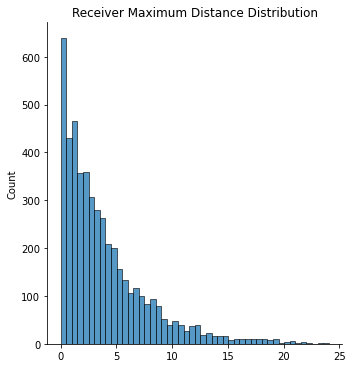

In [73]:
sns.displot([elem for elem in max_receiver_valueList if elem >0])
plt.title("Receiver Maximum Distance Distribution")
plt.show()

In [74]:
import math

In [75]:
max_creator_dist = {}
for key in [elem for elem in LocationCheck1.keys() if not math.isnan(elem)]:
    max_creator_dist[key] = LocationCheck1[key].values.max()
    
for key in LocationCheck2.keys():
    max_creator_dist[key] = LocationCheck2[key].values.max()
for key in LocationCheck3.keys():
    max_creator_dist[key] = LocationCheck3[key].values.max()
for key in LocationCheck4.keys():
    max_creator_dist[key] = LocationCheck4[key].values.max()

In [76]:
max_creator_valueList = list(max_creator_dist.values())

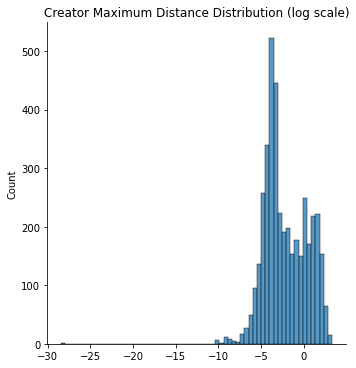

In [77]:
sns.displot([np.log(elem) for elem in max_creator_valueList if elem >0])
plt.title("Creator Maximum Distance Distribution (log scale)")
plt.show()

In [78]:
distance_percentile = pd.DataFrame([np.percentile(max_receiver_valueList,[50,75,90,95,99,100]),np.percentile(max_creator_valueList,[50,75,90,95,99,100])],
            columns=['50','75','90','95','99','100']
            ,index = ["max_receiver_distance","max_creator_distance"])

In [79]:
distance_percentile

,50,75,90,95,99,100
max_receiver_distance,0.023563,2.947456,6.557839,9.036724,15.295124,24.053444
max_creator_distance,0.000000,0.023405,0.728180,3.036204,8.854897,26.955966


In [80]:
### Examine Clusters

### for a given creator, find the number of creators nearby as supply, and number of receiver as demand
creatorLocationMap = {}
for key in LocationCluster1.keys():
    ## user key and cluster 1 location
    creatorLocationMap[(key,1)] = (LocationCluster1[key]["cluster1Center"][0],LocationCluster1[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationCluster1[key]["cluster2Index"]) != 0:
        creatorLocationMap[(key,2)] = (LocationCluster1[key]["cluster2Center"][0],LocationCluster1[key]["cluster2Center"][1])
    
for key in LocationCluster2.keys():
    ## user key and cluster 1 location
    creatorLocationMap[(key,1)] = (LocationCluster2[key]["cluster1Center"][0],LocationCluster2[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationCluster2[key]["cluster2Index"]) != 0:
        creatorLocationMap[(key,2)] = (LocationCluster2[key]["cluster2Center"][0],LocationCluster2[key]["cluster2Center"][1])

for key in LocationCluster3.keys():
    ## user key and cluster 1 location
    creatorLocationMap[(key,1)] = (LocationCluster3[key]["cluster1Center"][0],LocationCluster3[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationCluster3[key]["cluster2Index"]) != 0:
        creatorLocationMap[(key,2)] = (LocationCluster3[key]["cluster2Center"][0],LocationCluster3[key]["cluster2Center"][1])

for key in LocationCluster4.keys():
    ## user key and cluster 1 location
    creatorLocationMap[(key,1)] = (LocationCluster4[key]["cluster1Center"][0],LocationCluster4[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationCluster4[key]["cluster2Index"]) != 0:
        creatorLocationMap[(key,2)] = (LocationCluster4[key]["cluster2Center"][0],LocationCluster4[key]["cluster2Center"][1])
                  
    

In [81]:

articleCreatorLocationMap = {}
for key in LocationCluster1.keys():
    for article_id in LocationCluster1[key]['cluster1Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster1[key]['cluster1Center'][0],LocationCluster1[key]['cluster1Center'][1])
    for article_id in LocationCluster1[key]['cluster2Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster1[key]['cluster2Center'][0],LocationCluster1[key]['cluster2Center'][1])
        
    

In [82]:
for key in LocationCluster2.keys():
    for article_id in LocationCluster2[key]['cluster1Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster2[key]['cluster1Center'][0],LocationCluster2[key]['cluster1Center'][1])
    for article_id in LocationCluster2[key]['cluster2Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster2[key]['cluster2Center'][0],LocationCluster2[key]['cluster2Center'][1])
        

In [83]:
for key in LocationCluster3.keys():
    for article_id in LocationCluster3[key]['cluster1Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster3[key]['cluster1Center'][0],LocationCluster3[key]['cluster1Center'][1])
    for article_id in LocationCluster3[key]['cluster2Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster3[key]['cluster2Center'][0],LocationCluster3[key]['cluster2Center'][1])
        
    

In [84]:
for key in LocationCluster4.keys():
    for article_id in LocationCluster4[key]['cluster1Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster4[key]['cluster1Center'][0],LocationCluster4[key]['cluster1Center'][1])
    for article_id in LocationCluster4[key]['cluster2Index']:
        articleCreatorLocationMap[article_id] = (LocationCluster4[key]['cluster2Center'][0],LocationCluster4[key]['cluster2Center'][1])
        
    

In [85]:
undecide = {}
count = 0
for key in LocationCluster1.keys():
    if len(LocationCluster1[key]["cluster3Index"]) > 0:
        print(key,LocationCluster1[key]['articleValidPercent'])
        undecide[key] = LocationCluster1[key]['cluster3Index']
        print("The length of undecided article count:", len(LocationCluster1[key]["cluster3Index"]))
        count += len(LocationCluster1[key]["cluster3Index"])

2.0 0.9931972789115646
The length of undecided article count: 2
70.0 0.9980276134122288
The length of undecided article count: 1
4772.0 0.8666666666666667
The length of undecided article count: 2
5086.0 0.7777777777777778
The length of undecided article count: 6
5484.0 0.9305555555555556
The length of undecided article count: 35
5493.0 0.8983333333333333
The length of undecided article count: 61
5613.0 0.95
The length of undecided article count: 8
5816.0 0.8
The length of undecided article count: 1
6244.0 0.0
The length of undecided article count: 3
6996.0 0.9130434782608696
The length of undecided article count: 2
7397.0 0.9428571428571428
The length of undecided article count: 2
7490.0 0.8888888888888888
The length of undecided article count: 2
8234.0 0.0
The length of undecided article count: 2
8440.0 0.6666666666666667
The length of undecided article count: 2
8464.0 0.8
The length of undecided article count: 2
8465.0 0.2222222222222222
The length of undecided article count: 7
8466.

In [86]:
for key in LocationCluster2.keys():
    if len(LocationCluster2[key]["cluster3Index"]) > 0:
        print(key,LocationCluster2[key]['articleValidPercent'])
        undecide[key] = LocationCluster2[key]['cluster3Index']
        print("The length of undecided article count:", len(LocationCluster2[key]["cluster3Index"]))
        count += len(LocationCluster2[key]["cluster3Index"])

59529.0 0.0
The length of undecided article count: 2
60980.0 0.3157894736842105
The length of undecided article count: 13
64580.0 0.9924812030075187
The length of undecided article count: 1
66805.0 0.9459459459459459
The length of undecided article count: 2
73343.0 0.0
The length of undecided article count: 6
86427.0 0.0
The length of undecided article count: 2
93430.0 0.9130434782608696
The length of undecided article count: 2
96629.0 0.9285714285714286
The length of undecided article count: 1
97472.0 0.0
The length of undecided article count: 9
115902.0 0.0
The length of undecided article count: 4
117303.0 0.0
The length of undecided article count: 2
128348.0 0.0
The length of undecided article count: 2
132849.0 0.0
The length of undecided article count: 2
147531.0 0.9987389659520807
The length of undecided article count: 1
154834.0 0.9
The length of undecided article count: 2
155943.0 0.9642857142857143
The length of undecided article count: 2
156695.0 0.33333333333333337
The length

In [87]:
for key in LocationCluster3.keys():
    if len(LocationCluster3[key]["cluster3Index"]) > 0:
        print(key,LocationCluster3[key]['articleValidPercent'])
        undecide[key] = LocationCluster3[key]['cluster3Index']
        print("The length of undecided article count:", len(LocationCluster3[key]["cluster3Index"]))
        count += len(LocationCluster3[key]["cluster3Index"])

220746.0 0.0
The length of undecided article count: 8
224593.0 0.9821428571428571
The length of undecided article count: 1
228827.0 0.9166666666666666
The length of undecided article count: 1
235976.0 0.0
The length of undecided article count: 2
243662.0 0.0
The length of undecided article count: 6
264142.0 0.0
The length of undecided article count: 2
271995.0 0.0
The length of undecided article count: 2
282786.0 0.0
The length of undecided article count: 2
324120.0 0.0
The length of undecided article count: 17
332754.0 0.0
The length of undecided article count: 2
333937.0 0.33333333333333337
The length of undecided article count: 2
334879.0 0.0
The length of undecided article count: 2
360147.0 0.0
The length of undecided article count: 2
364359.0 0.9959183673469387
The length of undecided article count: 1
369653.0 0.0
The length of undecided article count: 4


In [88]:
for key in LocationCluster4.keys():
    if len(LocationCluster4[key]["cluster3Index"]) > 0:
        print(key,LocationCluster4[key]['articleValidPercent'])
        undecide[key] = LocationCluster4[key]['cluster3Index']
        print("The length of undecided article count:", len(LocationCluster4[key]["cluster3Index"]))
        count += len(LocationCluster4[key]["cluster3Index"])

417934.0 0.0
The length of undecided article count: 2
427250.0 0.9047619047619048
The length of undecided article count: 2
435661.0 0.0
The length of undecided article count: 2
436202.0 0.7886178861788617
The length of undecided article count: 26
465646.0 0.0
The length of undecided article count: 2
540688.0 0.33333333333333337
The length of undecided article count: 14
563758.0 0.0
The length of undecided article count: 16
603653.0 0.19999999999999996
The length of undecided article count: 4
634428.0 0.0
The length of undecided article count: 2


In [89]:
count

434

In [90]:
### map the user location
london_transaction["creator_location"] = london_transaction["article_id"].apply(lambda x:articleCreatorLocationMap[x] if x in articleCreatorLocationMap.keys() else None)

In [91]:
len(set(london_transaction.loc[london_transaction["creator_location"].isnull(),"article_id"]))

439

In [92]:
len(set(london_transaction.loc[london_transaction["creator_location"].isnull(),"creator_id"]))

93

In [93]:
creator_location_count = london_transaction[london_transaction["creator_location"].notnull()].groupby("creator_id",as_index=False).agg({'creator_location':pd.Series.nunique})

In [94]:
import collections

In [95]:
london_transaction = london_transaction[london_transaction["creator_id"].notnull()]

In [96]:
## define three categories of users
universal = set(london_transaction["creator_id"]).intersection(set(london_transaction.loc[london_transaction["receiver_id"].notnull(),"receiver_id"]))
receiver_only = set(london_transaction.loc[london_transaction["receiver_id"].notnull(),"receiver_id"]) - universal
creator_only = set(london_transaction["creator_id"]) - universal



In [97]:
collections.Counter(creator_location_count["creator_location"])

Counter({1: 11051, 2: 368})

In [98]:
len(creator_only) + len(universal)

11453

In [99]:
LocationReceiverCluster1

{2.0: {'cluster1Index': Int64Index([170212, 80137, 80138, 86700, 124016, 86705, 90777], dtype='int64'),
  'cluster2Index': Int64Index([], dtype='int64'),
  'cluster3Index': Int64Index([], dtype='int64'),
  'cluster1Center': array([51.567605, -0.098518]),
  'cluster2Center': array([nan, nan]),
  'clusterSize': [7, 0, 0],
  'articleValidPercent': 1.0},
 3.0: {'cluster1Index': Int64Index([], dtype='int64'),
  'cluster2Index': Int64Index([], dtype='int64'),
  'cluster3Index': Int64Index([190242, 212740], dtype='int64'),
  'cluster1Center': array([nan, nan]),
  'cluster2Center': array([nan, nan]),
  'clusterSize': [0, 0, 2],
  'articleValidPercent': 0.0},
 4.0: {'cluster1Index': Int64Index([169884, 46844, 43807], dtype='int64'),
  'cluster2Index': Int64Index([], dtype='int64'),
  'cluster3Index': Int64Index([], dtype='int64'),
  'cluster1Center': array([51.5717 , -0.11971]),
  'cluster2Center': array([nan, nan]),
  'clusterSize': [3, 0, 0],
  'articleValidPercent': 1.0},
 22.0: {'cluster1In

In [100]:
### Process receiver location

articleReceiverLocationMap = {}
for key in LocationReceiverCluster1.keys():
    for article_id in LocationReceiverCluster1[key]['cluster1Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster1[key]['cluster1Center'][0],LocationReceiverCluster1[key]['cluster1Center'][1])
    for article_id in LocationReceiverCluster1[key]['cluster2Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster1[key]['cluster2Center'][0],LocationReceiverCluster1[key]['cluster2Center'][1])
        
for key in LocationReceiverCluster2.keys():
    for article_id in LocationReceiverCluster2[key]['cluster1Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster2[key]['cluster1Center'][0],LocationReceiverCluster2[key]['cluster1Center'][1])
    for article_id in LocationReceiverCluster2[key]['cluster2Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster2[key]['cluster2Center'][0],LocationReceiverCluster2[key]['cluster2Center'][1])
        
for key in LocationReceiverCluster3.keys():
    for article_id in LocationReceiverCluster3[key]['cluster1Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster3[key]['cluster1Center'][0],LocationReceiverCluster3[key]['cluster1Center'][1])
    for article_id in LocationReceiverCluster3[key]['cluster2Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster3[key]['cluster2Center'][0],LocationReceiverCluster3[key]['cluster2Center'][1])
        
for key in LocationReceiverCluster4.keys():
    for article_id in LocationReceiverCluster4[key]['cluster1Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster4[key]['cluster1Center'][0],LocationReceiverCluster4[key]['cluster1Center'][1])
    for article_id in LocationReceiverCluster4[key]['cluster2Index']:
        articleReceiverLocationMap[(key,article_id)] = (LocationReceiverCluster4[key]['cluster2Center'][0],LocationReceiverCluster4[key]['cluster2Center'][1])
       

In [101]:
undecide_receiver = {}
count = 0
for key in LocationReceiverCluster1.keys():
    if len(LocationReceiverCluster1[key]["cluster3Index"]) > 0:
        print(key,LocationReceiverCluster1[key]['articleValidPercent'])
        undecide_receiver[key] = LocationReceiverCluster1[key]['cluster3Index']
        print("The length of undecide_receiverd article count:", len(LocationReceiverCluster1[key]["cluster3Index"]))
        count += len(LocationReceiverCluster1[key]["cluster3Index"])

for key in LocationReceiverCluster2.keys():
    if len(LocationReceiverCluster2[key]["cluster3Index"]) > 0:
        print(key,LocationReceiverCluster2[key]['articleValidPercent'])
        undecide_receiver[key] = LocationReceiverCluster2[key]['cluster3Index']
        print("The length of undecide_receiverd article count:", len(LocationReceiverCluster2[key]["cluster3Index"]))
        count += len(LocationReceiverCluster2[key]["cluster3Index"])

for key in LocationReceiverCluster3.keys():
    if len(LocationReceiverCluster3[key]["cluster3Index"]) > 0:
        print(key,LocationReceiverCluster3[key]['articleValidPercent'])
        undecide_receiver[key] = LocationReceiverCluster3[key]['cluster3Index']
        print("The length of undecide_receiverd article count:", len(LocationReceiverCluster3[key]["cluster3Index"]))
        count += len(LocationReceiverCluster3[key]["cluster3Index"])

for key in LocationReceiverCluster4.keys():
    if len(LocationReceiverCluster4[key]["cluster3Index"]) > 0:
        print(key,LocationReceiverCluster4[key]['articleValidPercent'])
        undecide_receiver[key] = LocationReceiverCluster4[key]['cluster3Index']
        print("The length of undecide_receiverd article count:", len(LocationReceiverCluster4[key]["cluster3Index"]))
        count += len(LocationReceiverCluster4[key]["cluster3Index"])     

3.0 0.0
The length of undecide_receiverd article count: 2
204.0 0.9197080291970803
The length of undecide_receiverd article count: 11
559.0 0.9936102236421726
The length of undecide_receiverd article count: 2
4978.0 0.9972067039106145
The length of undecide_receiverd article count: 2
5373.0 0.7426470588235294
The length of undecide_receiverd article count: 105
5764.0 0.96
The length of undecide_receiverd article count: 3
6216.0 0.6944444444444444
The length of undecide_receiverd article count: 11
7119.0 0.9709443099273608
The length of undecide_receiverd article count: 12
8946.0 0.9166666666666666
The length of undecide_receiverd article count: 1
9583.0 0.9910714285714286
The length of undecide_receiverd article count: 1
9778.0 0.8426573426573427
The length of undecide_receiverd article count: 45
10045.0 0.4
The length of undecide_receiverd article count: 1047
15446.0 0.704225352112676
The length of undecide_receiverd article count: 21
16746.0 0.4545454545454546
The length of undecide_

In [102]:
count

4029

In [103]:
len(undecide_receiver.keys())

277

In [104]:
### for a given receiver, find the number of receivers nearby as supply, and number of receiver as demand
receiverLocationMap = {}
for key in LocationReceiverCluster1.keys():
    ## user key and cluster 1 location
    receiverLocationMap[(key,1)] = (LocationReceiverCluster1[key]["cluster1Center"][0],LocationReceiverCluster1[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationReceiverCluster1[key]["cluster2Index"]) != 0:
        receiverLocationMap[(key,2)] = (LocationReceiverCluster1[key]["cluster2Center"][0],LocationReceiverCluster1[key]["cluster2Center"][1])
    
for key in LocationReceiverCluster2.keys():
    ## user key and cluster 1 location
    receiverLocationMap[(key,1)] = (LocationReceiverCluster2[key]["cluster1Center"][0],LocationReceiverCluster2[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationReceiverCluster2[key]["cluster2Index"]) != 0:
        receiverLocationMap[(key,2)] = (LocationReceiverCluster2[key]["cluster2Center"][0],LocationReceiverCluster2[key]["cluster2Center"][1])
for key in LocationReceiverCluster3.keys():
    ## user key and cluster 1 location
    receiverLocationMap[(key,1)] = (LocationReceiverCluster3[key]["cluster1Center"][0],LocationReceiverCluster3[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationReceiverCluster3[key]["cluster2Index"]) != 0:
        receiverLocationMap[(key,2)] = (LocationReceiverCluster3[key]["cluster2Center"][0],LocationReceiverCluster3[key]["cluster2Center"][1])
for key in LocationReceiverCluster4.keys():
    ## user key and cluster 1 location
    receiverLocationMap[(key,1)] = (LocationReceiverCluster4[key]["cluster1Center"][0],LocationReceiverCluster4[key]["cluster1Center"][1])
    ## user key and cluster 2 location
    if len(LocationReceiverCluster4[key]["cluster2Index"]) != 0:
        receiverLocationMap[(key,2)] = (LocationReceiverCluster4[key]["cluster2Center"][0],LocationReceiverCluster4[key]["cluster2Center"][1])
                  
    

In [105]:
len(creatorLocationMap.keys())

11821

In [106]:
receiverLocationMap

{(2.0, 1): (51.567605, -0.098518),
 (3.0, 1): (nan, nan),
 (4.0, 1): (51.5717, -0.11971),
 (22.0, 1): (51.59535, -0.134284),
 (33.0, 1): (51.603984000000004, -0.175278),
 (70.0, 1): (51.560342, -0.125815),
 (74.0, 1): (51.566946, -0.116798),
 (108.0, 1): (51.5753, -0.1231),
 (137.0, 1): (51.57585, -0.12979200000000002),
 (155.0, 1): (51.5203425, -0.1032875),
 (181.0, 1): (51.5414835, -0.09329),
 (189.0, 1): (51.5807, -0.12499),
 (204.0, 1): (51.611841, -0.1243255),
 (204.0, 2): (51.5264485, -0.0816955),
 (216.0, 1): (51.56238999999999, -0.08059949999999999),
 (216.0, 2): (51.6348, -0.11945),
 (221.0, 1): (51.5755, -0.12300000000000001),
 (251.0, 1): (51.5429, -0.029019999999999997),
 (252.0, 1): (51.561681, -0.11898199999999999),
 (260.0, 1): (51.598355, -0.127655),
 (266.0, 1): (51.582668, -0.11454600000000001),
 (298.0, 1): (51.5984165, -0.1276095),
 (315.0, 1): (51.567749, -0.095053),
 (388.0, 1): (51.598600000000005, -0.14470499999999997),
 (447.0, 1): (51.5858805, -0.104546),
 (51

In [107]:

creatorLocationMap

{(1.0, 1): (51.570567, -0.129911),
 (2.0, 1): (51.566846000000005, -0.11093700000000001),
 (3.0, 1): (51.583804, -0.100244),
 (4.0, 1): (51.5754, -0.123054),
 (4.0, 2): (51.544478999999995, -0.175425),
 (6.0, 1): (51.576707, -0.123088),
 (7.0, 1): (51.573688, -0.125541),
 (8.0, 1): (51.583156, -0.1285745),
 (9.0, 1): (51.573998, -0.136434),
 (9.0, 2): (51.607169, -0.291166),
 (10.0, 1): (51.5712245, -0.132467),
 (13.0, 1): (51.577415, -0.12338199999999999),
 (15.0, 1): (51.563583, -0.100036),
 (17.0, 1): (51.587495000000004, -0.10698800000000001),
 (22.0, 1): (51.5795, -0.147032),
 (25.0, 1): (51.5777, -0.117245),
 (29.0, 1): (51.584140000000005, -0.116066),
 (30.0, 1): (51.576556, -0.111972),
 (31.0, 1): (51.584391, -0.1002195),
 (33.0, 1): (51.589, -0.15919),
 (34.0, 1): (51.579251, -0.123431),
 (35.0, 1): (51.581339, -0.10191549999999999),
 (36.0, 1): (51.610421, -0.11909),
 (37.0, 1): (51.581728000000005, -0.123602),
 (39.0, 1): (51.497840999999994, -0.135022),
 (44.0, 1): (51.4223

In [ ]:

import pickle

In [ ]:
with open('IntermediateData/IntermediateCreatorLocation/creatorLocationMap.pickle', 'wb') as handle:
    pickle.dump(creatorLocationMap, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('IntermediateData/IntermediateReceiverLocation/receiverLocationMap.pickle', 'wb') as handle:
    pickle.dump(receiverLocationMap, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:

### map the receiver location
london_transaction["receiver_location"] = london_transaction[["receiver_id","article_id"]].apply(lambda x:articleReceiverLocationMap[(x["receiver_id"],x["article_id"])] if (x["receiver_id"],x["article_id"]) in articleReceiverLocationMap.keys() else None,axis=1)


/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
london_transaction[["creator_id","creator_location"]]

,creator_id,creator_location
0,2.0,"(51.566846000000005, -0.11093700000000001)"
1,2.0,"(51.566846000000005, -0.11093700000000001)"
2,3.0,"(51.583804, -0.100244)"
3,3.0,"(51.583804, -0.100244)"
4,7.0,"(51.573688, -0.125541)"
...,...,...
153067,369825.0,"(51.5149, -0.070183)"
153068,717471.0,"(51.555, 0.00779)"
153069,717471.0,"(51.555, 0.00779)"
153070,540230.0,"(51.4972, -0.19233)"


In [177]:
creatorDict = {}
for elem in creatorLocationMap.keys():
    value = creatorLocationMap[elem]
    ## user, location as key, 
    creatorDict[(elem[0], value)] = (elem[0],elem[1])
    

In [179]:
receiverDict = {}
for elem in receiverLocationMap.keys():
    value = receiverLocationMap[elem]
    ## user, location as key, 
    receiverDict[(elem[0], value)] = (elem[0],elem[1])
    

In [184]:

def getDistanceMatrix(creator_id):
    ## filter transaction dataset
    test = london_transaction[(london_transaction["creator_id"] == creator_id) 
                             & (london_transaction["article_lat"].notnull())
                             & (london_transaction["article_long"].notnull())].copy()
    
    ## create test_df
    print(test.shape)
    unique_articleId = list(set(test["article_id"].values))
    print(unique_articleId)
    test_df = pd.DataFrame(0.0,index = unique_articleId, columns = unique_articleId)
    
    for i in test_df.index:
        for j in test_df.columns:
            ## get lat and long for two articles
            
            lati = london_transaction.loc[london_transaction["article_id"] == i,"article_lat"].values[0]
            longi = london_transaction.loc[london_transaction["article_id"] == i,"article_long"].values[0]
            latj = london_transaction.loc[london_transaction["article_id"] == j,"article_lat"].values[0]
            longj = london_transaction.loc[london_transaction["article_id"] == j,"article_long"].values[0]
            dist = calculate_distance_haversine(lati,longi,latj,longj)
            test_df.loc[i,j] = dist
            print(i,j,dist)
    return test_df
        

In [185]:
getDistanceMatrix(5086)

(35, 41)
[646, 2568, 2570, 236557, 262287, 196510, 196511, 252451, 122927, 60858, 4295, 4296, 4297, 118345, 226126, 234454, 67544, 63706, 254427, 226140, 60764, 257248, 257249, 254562, 261742, 261743, 262268]
646 646 0.0
646 2568 9.290813109952172
646 2570 9.290813109952172
646 236557 2.713740170029103
646 262287 8.429516196478446
646 196510 8.461891577483625
646 196511 8.461891577483625
646 252451 2.6894545184796486
646 122927 8.432382458867071
646 60858 8.459737737110162
646 4295 9.30498141519432
646 4296 9.305340415484972
646 4297 9.290813109952172
646 118345 2.6962038801199575
646 226126 2.7109805484919174
646 234454 2.7109805484919174
646 67544 2.6962038801199575
646 63706 2.706004414978103
646 254427 2.713740170029103
646 226140 2.7109805484919174
646 60764 2.7048894458772783
646 257248 2.713740170029103
646 257249 2.713740170029103
646 254562 8.461891577483625
646 261742 2.713740170029103
646 261743 2.713740170029103
646 262268 8.429834105877704
2568 646 9.290813109952172
2568 2

4295 262268 6.445040918504793
4296 646 9.305340415484972
4296 2568 0.03701894828992346
4296 2570 0.03701894828992346
4296 236557 6.594011990752815
4296 262287 6.449197351717623
4296 196510 6.440627959645139
4296 196511 6.440627959645139
4296 252451 6.618341788710607
4296 122927 6.449833353369726
4296 60858 6.457273066529692
4296 4295 0.0017260817024670346
4296 4296 0.0
4296 4297 0.03701894828992346
4296 118345 6.611671474013594
4296 226126 6.597317519398536
4296 234454 6.597317519398536
4296 67544 6.611671474013594
4296 63706 6.601746267408178
4296 254427 6.594011990752815
4296 226140 6.597317519398536
4296 60764 6.602903395495356
4296 257248 6.594011990752815
4296 257249 6.594011990752815
4296 254562 6.440627959645139
4296 261742 6.594011990752815
4296 261743 6.594011990752815
4296 262268 6.446696729541997
4297 646 9.290813109952172
4297 2568 0.0
4297 2570 0.0
4297 236557 6.579013997504664
4297 262287 6.472240749825203
4297 196510 6.463830365783051
4297 196511 6.463830365783051
4297 2

257248 60764 0.008910622556147876
257248 257248 0.0
257248 257249 0.0
257248 254562 6.785769685192938
257248 261742 0.0
257248 261743 0.0
257248 262268 6.758968838205428
257249 646 2.713740170029103
257249 2568 6.579013997504664
257249 2570 6.579013997504664
257249 236557 0.0
257249 262287 6.759408084532149
257249 196510 6.785769685192938
257249 196511 6.785769685192938
257249 252451 0.02433122442715655
257249 122927 6.762144422899198
257249 60858 6.788642111985324
257249 4295 6.593677745842822
257249 4296 6.594011990752815
257249 4297 6.579013997504664
257249 118345 0.017770034558139112
257249 226126 0.01077820981264367
257249 234454 0.01077820981264367
257249 67544 0.017770034558139112
257249 63706 0.007737500071788582
257249 254427 0.0
257249 226140 0.01077820981264367
257249 60764 0.008910622556147876
257249 257248 0.0
257249 257249 0.0
257249 254562 6.785769685192938
257249 261742 0.0
257249 261743 0.0
257249 262268 6.758968838205428
254562 646 8.461891577483625
254562 2568 6.4638

,646,2568,2570,236557,262287,196510,196511,252451,122927,60858,...,63706,254427,226140,60764,257248,257249,254562,261742,261743,262268
646,0.000000,9.290813,9.290813,2.713740,8.429516,8.461892,8.461892,2.689455,8.432382,8.459738,...,2.706004,2.713740,2.710981,2.704889,2.713740,2.713740,8.461892,2.713740,2.713740,8.429834
2568,9.290813,0.000000,0.000000,6.579014,6.472241,6.463830,6.463830,6.603342,6.472889,6.480447,...,6.586749,6.579014,6.582267,6.587902,6.579014,6.579014,6.463830,6.579014,6.579014,6.469744
2570,9.290813,0.000000,0.000000,6.579014,6.472241,6.463830,6.463830,6.603342,6.472889,6.480447,...,6.586749,6.579014,6.582267,6.587902,6.579014,6.579014,6.463830,6.579014,6.579014,6.469744
236557,2.713740,6.579014,6.579014,0.000000,6.759408,6.785770,6.785770,0.024331,6.762144,6.788642,...,0.007738,0.000000,0.010778,0.008911,0.000000,0.000000,6.785770,0.000000,0.000000,6.758969
262287,8.429516,6.472241,6.472241,6.759408,0.000000,0.036513,0.036513,6.772648,0.002867,0.030232,...,6.763350,6.759408,6.769846,6.764652,6.759408,6.759408,0.036513,6.759408,6.759408,0.002673
196510,8.461892,6.463830,6.463830,6.785770,0.036513,0.000000,0.000000,6.799085,0.033973,0.017834,...,6.789737,6.785770,6.796198,6.791041,6.785770,6.785770,0.000000,6.785770,6.785770,0.035072
196511,8.461892,6.463830,6.463830,6.785770,0.036513,0.000000,0.000000,6.799085,0.033973,0.017834,...,6.789737,6.785770,6.796198,6.791041,6.785770,6.785770,0.000000,6.785770,6.785770,0.035072
252451,2.689455,6.603342,6.603342,0.024331,6.772648,6.799085,6.799085,0.000000,6.775387,6.801905,...,0.016603,0.024331,0.023287,0.015442,0.024331,0.024331,6.799085,0.024331,0.024331,6.772216
122927,8.432382,6.472889,6.472889,6.762144,0.002867,0.033973,0.033973,6.775387,0.000000,0.027368,...,6.766088,6.762144,6.772582,6.767390,6.762144,6.762144,0.033973,6.762144,6.762144,0.003642
60858,8.459738,6.480447,6.480447,6.788642,0.030232,0.017834,0.017834,6.801905,0.027368,0.000000,...,6.792592,6.788642,6.799077,6.793895,6.788642,6.788642,0.017834,6.788642,6.788642,0.030102


In [183]:
london_transaction[london_transaction["creator_id"] == 5086]

,article_id,creator_id,receiver_id,pickup_id,pickup,article_created_at,pickup_created_at,article_lat,article_long,title,...,creator_postcode,creator_country,receiver_address,receiver_city_district,receiver_city,receiver_state_district,receiver_state,receiver_postcode,receiver_country,creator_receiver_distance
645,646,5086.0,NaN,NaN,0,2015-09-14 05:54:00,NaN,51.557651,-0.116214,Various food,...,None,None,None,None,None,None,None,None,None,NaN
2542,2568,5086.0,NaN,NaN,0,2015-12-23 14:46:00,NaN,51.427600,-0.170374,Stuffing,...,None,None,None,None,None,None,None,None,None,NaN
2544,2570,5086.0,NaN,NaN,0,2015-12-23 15:02:00,NaN,51.427600,-0.170374,Plastic food tubs,...,None,None,None,None,None,None,None,None,None,NaN
3615,4295,5086.0,NaN,NaN,0,2016-03-02 09:33:00,NaN,51.427273,-0.169653,Black peas,...,None,None,None,None,None,None,None,None,None,NaN
3616,4296,5086.0,NaN,NaN,0,2016-03-02 09:35:00,NaN,51.427274,-0.169693,Rice flour,...,None,None,None,None,None,None,None,None,None,NaN
3617,4297,5086.0,NaN,NaN,0,2016-03-02 09:39:00,NaN,51.427600,-0.170374,Tamarind paste,...,None,None,None,None,None,None,None,None,None,NaN
36446,60764,5086.0,NaN,NaN,0,2017-06-27 18:48:00,NaN,51.520127,-0.133965,Free pizza,...,W1T 2ES,United Kingdom,None,None,None,None,None,None,None,NaN
36528,60858,5086.0,211250.0,14449.0,1,2017-06-27 21:41:00,2017-06-30 22:44:00,51.449547,-0.024220,Moving boxes,...,SE6 4FB,United Kingdom,"Appleby Court, Adenmore Road, Catford Green, L...",London Borough of Lewisham,London,Greater London,England,SE6 4DZ,United Kingdom,0.014653
38748,63706,5086.0,44030.0,15900.0,1,2017-07-07 15:07:00,2017-07-07 16:19:00,51.520108,-0.133953,In date milk,...,W1T 2ES,United Kingdom,"Lewis Leathers Ltd, 3-5, Whitfield Street, St ...",London Borough of Camden,London,Greater London,England,W1T 2SA,United Kingdom,0.061057
41511,67544,5086.0,223981.0,18580.0,0,2017-07-21 15:29:00,2017-07-21 16:00:00,51.520255,-0.133949,Chicken/Lamb shawarma,...,W1T 2ES,United Kingdom,"Pall Mall Barbers, York Way, Pentonville, King...",London Borough of Islington,London,Greater London,England,N1 9FA,United Kingdom,1.098617


In [190]:
london_transaction.loc[london_transaction["creator_location"].isnull(),["creator_id"]]

,creator_id
645,5086.0
1382,4772.0
1981,6244.0
2040,5613.0
2044,5484.0
...,...
151149,563758.0
152053,324120.0
152607,563758.0
152628,563758.0


In [191]:
london_transaction["creatorLocationKey"] = london_transaction[["creator_id","creator_location"]].apply(lambda x:
                                                                                                      creatorDict[(x["creator_id"],x["creator_location"])] if x["creator_location"]!= None else None,axis=1)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [195]:
london_transaction["receiverLocationKey"] = london_transaction[["receiver_id","receiver_location"]].apply(lambda x:
                                                                                                      receiverDict[(x["receiver_id"],x["receiver_location"])] if x["receiver_location"]!= None else None,axis=1)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
len(set(london_transaction.loc[(london_transaction["receiver_id"].notnull())
                       & (london_transaction["receiver_location"].isnull()),"receiver_id"]))

277

In [110]:
len(set(london_transaction.loc[(london_transaction["receiver_id"].notnull())
                       & (london_transaction["receiver_location"].isnull()),"article_id"]))

3898

In [111]:
len(set(london_transaction.loc[london_transaction["receiver_id"].notnull(),"article_id"]))

62847

In [112]:
### There are 62758 articles that are picked up in the regression
len(set(london_transaction.loc[
    (london_transaction["receiver_id"].notnull()) 
    & (london_transaction["creator_location"].notnull())
   ,"article_id"
]))

62758

In [113]:
len(set(london_transaction.loc[
    (london_transaction["receiver_id"].notnull()) 
    
    & (london_transaction["receiver_location"].notnull()),"article_id"
]))

60079

In [114]:
len(set(london_transaction.loc[
    (london_transaction["receiver_id"].notnull()) 
    & (london_transaction["creator_location"].notnull())
    & (london_transaction["receiver_location"].notnull()),"article_id"
]))

59995

In [115]:
(62758 - 59995) / 62758

0.044026259600369676

In [116]:
receiver_location_count = london_transaction.loc[(london_transaction["receiver_id"].notnull()) &
    (london_transaction["receiver_location"].notnull())].groupby("receiver_id",as_index=False).agg({'receiver_location':pd.Series.nunique})




In [117]:
collections.Counter(receiver_location_count["receiver_location"])

Counter({1: 8676, 2: 620})

In [118]:
len(set(london_transaction.loc[(london_transaction["creator_location"].notnull()),"creator_location"]))

11597

In [119]:
len(set(london_transaction.loc[(london_transaction["receiver_location"].notnull()),"receiver_location"]))

6331

In [120]:
creator_list = sorted(list(set(london_transaction.loc[(london_transaction["creator_location"].notnull()),"creator_location"])))

In [121]:
receiver_list = sorted(list(set(london_transaction.loc[(london_transaction["receiver_location"].notnull()),"receiver_location"])))

In [122]:


def getAddress(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("display_name",0)
    except TypeError:
        return "LocationNotFound"
    
def getBorough(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'

    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("city_state",0)
    except TypeError:
        return "LocationNotFound"
    
    
def getCity(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("city",0)
    except TypeError:
        return "LocationNotFound"

def getPostcode(lat,long):

    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'    

    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    try:
        location = locator.reverse(coordinate)
        return location.raw.get("address",0).get("postcode",0)
    except TypeError:
        return "LocationNotFound"


def getInfo(lat,long):
    if str(lat) == 'nan' or str(long) == 'nan':
        return 'nan'
    
    coordinate = str(round(lat,3)) + "," + str(round(long,3))
    print(coordinate)
    location = locator.reverse(coordinate)
    if location != None:
        return location.raw
    else:
        return "LocationNotFound"
    




In [123]:
creator_location_save = "IntermediateData/IntermediateCreatorLocation/"
receiver_location_save = "IntermediateData/IntermediateReceiverLocation/"

In [124]:
locator = Nominatim(user_agent='Geocoder')

In [ ]:
len(creator_list) / 4

In [ ]:
#print("The first part of location")
creator_loc_dict1 = {}
for elem in creator_list[:2900]:
    result = getInfo(elem[0],elem[1])
    creator_loc_dict1[elem] = result
    
with open(creator_location_save + 'creator_loc_dict1_0608.pickle', 'wb') as handle:
    pickle.dump(creator_loc_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
creator_loc_dict2 = {}
for elem in creator_list[2900:5800]:
    result = getInfo(elem[0],elem[1])
    creator_loc_dict2[elem] = result
    
with open(creator_location_save + 'creator_loc_dict2_0608.pickle', 'wb') as handle:
    pickle.dump(creator_loc_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

creator_loc_dict3 = {}
for elem in creator_list[5800:8700]:
    result = getInfo(elem[0],elem[1])
    creator_loc_dict3[elem] = result
    
with open(creator_location_save + 'creator_loc_dict3_0608.pickle', 'wb') as handle:
    pickle.dump(creator_loc_dict3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
creator_loc_dict4 = {}
for elem in creator_list[8700:]:
    result = getInfo(elem[0],elem[1])
    creator_loc_dict4[elem] = result
    
with open(creator_location_save + 'creator_loc_dict4_0608.pickle', 'wb') as handle:
    pickle.dump(creator_loc_dict4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
len(creator_loc_dict4)

In [ ]:
for elem in creator_list[11500:]:
    result = getInfo(elem[0],elem[1])
    creator_loc_dict4[elem] = result
    
with open(creator_location_save + 'creator_loc_dict4_0608.pickle', 'wb') as handle:
    pickle.dump(creator_loc_dict4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
receiver_loc_dict1 = {}
for elem in receiver_list[:1600]:
    result = getInfo(elem[0],elem[1])
    receiver_loc_dict1[elem] = result
    
with open(receiver_location_save + 'receiver_loc_dict1_0608.pickle', 'wb') as handle:
    pickle.dump(receiver_loc_dict1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
receiver_loc_dict2 = {}
for elem in receiver_list[1600:3200]:
    result = getInfo(elem[0],elem[1])
    receiver_loc_dict2[elem] = result
    
with open(receiver_location_save + 'receiver_loc_dict2_0608.pickle', 'wb') as handle:
    pickle.dump(receiver_loc_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

receiver_loc_dict3 = {}
for elem in receiver_list[3200:4800]:
    result = getInfo(elem[0],elem[1])
    receiver_loc_dict3[elem] = result
    
with open(receiver_location_save + 'receiver_loc_dict3_0608.pickle', 'wb') as handle:
    pickle.dump(receiver_loc_dict3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
receiver_loc_dict4 = {}
for elem in receiver_list[4800:]:
    result = getInfo(elem[0],elem[1])
    receiver_loc_dict4[elem] = result
    
with open(receiver_location_save + 'receiver_loc_dict4_0608.pickle', 'wb') as handle:
    pickle.dump(receiver_loc_dict4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [125]:
### map creator and receiver location

## receiver
with open('IntermediateData/IntermediateReceiverLocation/receiver_loc_dict1_0608.pickle', 'rb') as handle:
    LocationRec1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/receiver_loc_dict2_0608.pickle', 'rb') as handle:
    LocationRec2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateReceiverLocation/receiver_loc_dict3_0608.pickle', 'rb') as handle:
    LocationRec3 = pickle.load(handle)

with open('IntermediateData/IntermediateReceiverLocation/receiver_loc_dict4_0608.pickle', 'rb') as handle:
    LocationRec4 = pickle.load(handle)

In [126]:
with open('IntermediateData/IntermediateCreatorLocation/creator_loc_dict1_0608.pickle', 'rb') as handle:
    LocationCre1 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/creator_loc_dict2_0608.pickle', 'rb') as handle:
    LocationCre2 = pickle.load(handle)
    
with open('IntermediateData/IntermediateCreatorLocation/creator_loc_dict3_0608.pickle', 'rb') as handle:
    LocationCre3 = pickle.load(handle)

with open('IntermediateData/IntermediateCreatorLocation/creator_loc_dict4_0608.pickle', 'rb') as handle:
    LocationCre4 = pickle.load(handle)

In [127]:
LocationRec = {
    **LocationRec1,
    **LocationRec2,
    **LocationRec3,
    **LocationRec4
}

In [128]:
LocationCre = {
    **LocationCre1,
    **LocationCre2,
    **LocationCre3,
    **LocationCre4
}

In [129]:
def address_map(x,mapper):
    '''
    x: geom lat and long
    '''
    
    if x is None:
        return None
    elif mapper.get(x) == 'LocationNotFound':
        return 'LocationNotFound'
    else:
        return mapper[x]["display_name"]

In [130]:
def mapper(x,mapper, granularity = "city"):
    '''
    x: geom lat and long
    granularity: 
    'city_district': 'London Borough of Bexley',
   'city': 'London',
   'state_district': 'Greater London',
   'state': 'England',
   'postcode': 'DA8 3DR',
   'country': 'United Kingdom',
    '''
    
    if x is None:
        return None
    elif mapper.get(x) == 'LocationNotFound':
        return 'LocationNotFound'
    else:
        return mapper[x].get("address","No Info").get(granularity,granularity + " NA")

In [131]:
london_transaction.loc[london_transaction["creator_location"].isnull(),"creator_location"]

645       None
1382      None
1981      None
2040      None
2044      None
          ... 
151149    None
152053    None
152607    None
152628    None
152659    None
Name: creator_location, Length: 445, dtype: object

In [132]:
london_transaction['creator_address'] = london_transaction["creator_location"].apply(lambda x: address_map(x,LocationCre))
london_transaction['creator_city_district'] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'city_district'))
                                                        
london_transaction['creator_city'] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'city'))
                                                        
london_transaction["creator_state_district"] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'state_district'))
 
    
london_transaction["creator_state"] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'state'))


london_transaction["creator_postcode"] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'postcode'))
                                                        
london_transaction["creator_country"] = london_transaction["creator_location"].apply(lambda x: 
                                    mapper(x,LocationCre,'country')) 


/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [133]:

london_transaction['receiver_address'] = london_transaction["receiver_location"].apply(lambda x: address_map(x,LocationRec))
london_transaction['receiver_city_district'] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'city_district'))
                                                        
london_transaction['receiver_city'] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'city'))
                                                        
london_transaction["receiver_state_district"] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'state_district'))
 
    
london_transaction["receiver_state"] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'state'))


london_transaction["receiver_postcode"] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'postcode'))
                                                        
london_transaction["receiver_country"] = london_transaction["receiver_location"].apply(lambda x: 
                                    mapper(x,LocationRec,'country')) 

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [134]:
london_transaction.columns

Index(['article_id', 'creator_id', 'receiver_id', 'pickup_id', 'pickup',
       'article_created_at', 'pickup_created_at', 'article_lat',
       'article_long', 'title', 'description', 'collection_notes', 'status',
       'collection_id', 'time_diff_inHours', 'article_geom',
       'article_city_district', 'article_city', 'article_state_district',
       'article_state', 'article_postcode', 'article_country',
       'article_neighbourhood', 'article_city_district_neighbourhood_concat',
       'creator_location', 'receiver_location', 'creator_address',
       'creator_city_district', 'creator_city', 'creator_state_district',
       'creator_state', 'creator_postcode', 'creator_country',
       'receiver_address', 'receiver_city_district', 'receiver_city',
       'receiver_state_district', 'receiver_state', 'receiver_postcode',
       'receiver_country'],
      dtype='object')

In [135]:
collections.Counter(london_transaction["article_city_district"])

Counter({'London Borough of Haringey': 15230,
         'London Borough of Islington': 16261,
         'London Borough of Barnet': 7546,
         'London Borough of Hackney': 15019,
         'city_district NA': 20286,
         'London Borough of Newham': 3237,
         'London Borough of Camden': 12509,
         'London Borough of Enfield': 4570,
         'London Borough of Waltham Forest': 2827,
         'London Borough of Wandsworth': 3747,
         'London Borough of Lambeth': 6101,
         'Royal Borough of Kensington and Chelsea': 1759,
         'London Borough of Harrow': 396,
         'London Borough of Southwark': 12461,
         'London Borough of Merton': 2393,
         'London Borough of Barking and Dagenham': 284,
         'London Borough of Bexley': 517,
         'London Borough of Croydon': 2638,
         'London Borough of Brent': 4460,
         'London Borough of Hammersmith and Fulham': 5004,
         'London Borough of Bromley': 1482,
         'London Borough of Richm

In [136]:
collections.Counter(london_transaction["creator_city_district"])

Counter({'London Borough of Islington': 15977,
         'London Borough of Haringey': 14991,
         'London Borough of Hackney': 15324,
         'London Borough of Barnet': 7573,
         'London Borough of Enfield': 4615,
         None: 445,
         'city_district NA': 20294,
         'London Borough of Camden': 12632,
         'London Borough of Southwark': 12526,
         'London Borough of Waltham Forest': 2717,
         'London Borough of Wandsworth': 3762,
         'Royal Borough of Kensington and Chelsea': 1591,
         'London Borough of Lambeth': 6157,
         'London Borough of Harrow': 376,
         'London Borough of Merton': 2431,
         'London Borough of Croydon': 2514,
         'London Borough of Brent': 4371,
         'London Borough of Hammersmith and Fulham': 4904,
         'London Borough of Bromley': 1466,
         'London Borough of Newham': 3247,
         'London Borough of Lewisham': 3889,
         'London Borough of Ealing': 1890,
         'London Boroug

In [137]:
collections.Counter(london_transaction["receiver_city_district"])

Counter({None: 64159,
         'London Borough of Hackney': 9808,
         'London Borough of Haringey': 7570,
         'London Borough of Camden': 7170,
         'London Borough of Islington': 11938,
         'city_district NA': 11737,
         'London Borough of Lambeth': 3362,
         'London Borough of Southwark': 8514,
         'London Borough of Bromley': 762,
         'London Borough of Newham': 853,
         'London Borough of Wandsworth': 1528,
         'Royal Borough of Greenwich': 1309,
         'London Borough of Barnet': 5053,
         'London Borough of Brent': 2869,
         'London Borough of Enfield': 3171,
         'Royal Borough of Kensington and Chelsea': 857,
         'London Borough of Ealing': 698,
         'London Borough of Hammersmith and Fulham': 3067,
         'London Borough of Waltham Forest': 1117,
         'London Borough of Richmond upon Thames': 571,
         'London Borough of Barking and Dagenham': 89,
         'London Borough of Lewisham': 1413,
  

In [146]:
london_transaction["creator_location"][0][0]

51.566846000000005

In [151]:
london_transaction["creator_receiver_distance"] = london_transaction.apply(
lambda x: calculate_distance_haversine(x["creator_location"][0],x["creator_location"][1],
                                       x["receiver_location"][0],x["receiver_location"][1]) 
    if ((x["creator_location"]!= None) and (x["receiver_location"]!=None)) else None,axis=1)


/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Distribution of Creator Receiver Distance')

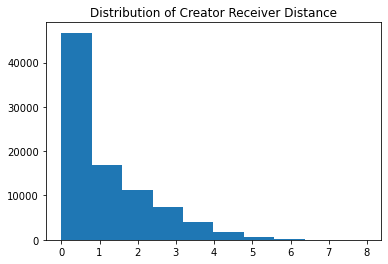

In [163]:
plt.hist(london_transaction["creator_receiver_distance"])
plt.title("Distribution of Creator Receiver Distance")

In [164]:
pd.DataFrame(np.percentile(london_transaction.loc[london_transaction["creator_receiver_distance"].notnull(),["creator_receiver_distance"]],[50,75,90,95,99]))

,0
0,0.704107
1,1.778284
2,2.887322
3,3.530174
4,4.741228


/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='creator_receiver_distance', ylabel='Density'>

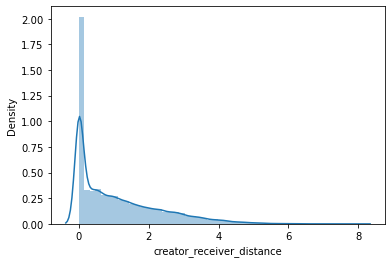

In [155]:
sns.distplot(london_transaction["creator_receiver_distance"])

In [197]:
london_transaction

,article_id,creator_id,receiver_id,pickup_id,pickup,article_created_at,pickup_created_at,article_lat,article_long,title,...,receiver_address,receiver_city_district,receiver_city,receiver_state_district,receiver_state,receiver_postcode,receiver_country,creator_receiver_distance,creatorLocationKey,receiverLocationKey
0,1,2.0,NaN,NaN,0,2015-07-09 11:25:00,NaN,51.575572,-0.123625,Two packets of green lentils,...,None,None,None,None,None,None,None,NaN,"(2.0, 1)",None
1,2,2.0,NaN,NaN,0,2015-07-09 11:45:00,NaN,51.575662,-0.123365,All Bran 750g,...,None,None,None,None,None,None,None,NaN,"(2.0, 1)",None
2,3,3.0,NaN,NaN,0,2015-07-09 12:00:00,NaN,51.583772,-0.100280,Half price Vadasz Deli pickles and relish,...,None,None,None,None,None,None,None,NaN,"(3.0, 1)",None
3,4,3.0,NaN,NaN,0,2015-07-09 12:04:00,NaN,51.583815,-0.100250,Goats cheese & sundries tomato burgers,...,None,None,None,None,None,None,None,NaN,"(3.0, 1)",None
4,5,7.0,NaN,NaN,0,2015-07-09 13:34:00,NaN,51.573706,-0.127276,Dijon Mustard - unopened,...,None,None,None,None,None,None,None,NaN,"(7.0, 1)",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153067,264576,369825.0,333206.0,187610.0,0,2018-10-30 16:35:00,2018-10-30 17:04:00,51.515000,-0.070000,"Pret A Manger - sandwiches, baguettes, yogurts...",...,"23, Deal Street, Spitalfields, Whitechapel, Lo...",city_district NA,London,Greater London,England,E1 5AH,United Kingdom,0.435932,"(369825.0, 1)","(333206.0, 1)"
153068,264578,717471.0,NaN,NaN,0,2018-10-30 16:35:00,NaN,51.555000,0.007580,5 x Cherry Coca-Cola cans,...,None,None,None,None,None,None,None,NaN,"(717471.0, 1)",None
153069,264581,717471.0,NaN,NaN,0,2018-10-30 16:37:00,NaN,51.555000,0.008000,Rock candy pack,...,None,None,None,None,None,None,None,NaN,"(717471.0, 1)",None
153070,264583,540230.0,NaN,NaN,0,2018-10-30 16:39:00,NaN,51.497200,-0.192330,Japanese golden curry sauce mix,...,None,None,None,None,None,None,None,NaN,"(540230.0, 1)",None


In [198]:
### load the neighborhood information for the creator

with open('IntermediateData/creator_neighbor_supply500m.pickle', 'rb') as handle:
    creatorNeighSupply500m = pickle.load(handle)
    
with open('IntermediateData/creator_neighbor_supply2000m.pickle', 'rb') as handle:
    creatorNeighSupply2000m = pickle.load(handle)
    
with open('IntermediateData/creator_neighbor_supply5000m.pickle', 'rb') as handle:
    creatorNeighSupply5000m = pickle.load(handle)



In [209]:
def getNeighbor(x, neighBor):
    
    if x == None:
        return None
    if x[1] == 1:
        return neighBor[x[0]]
    else:
        return neighBor[x]
    
    

In [211]:
london_transaction["creatorNeighSupply500m"] = london_transaction["creatorLocationKey"].apply(lambda x: getNeighbor(x,creatorNeighSupply500m))

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [212]:
london_transaction["creatorNeighSupply2000m"] = london_transaction["creatorLocationKey"].apply(lambda x: 
                                                                    getNeighbor(x,creatorNeighSupply2000m))

london_transaction["creatorNeighSupply5000m"] = london_transaction["creatorLocationKey"].apply(lambda x: 
                                                                    getNeighbor(x,creatorNeighSupply5000m))


/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [213]:

with open('IntermediateData/creator_neighbor_Demand500m.pickle', 'rb') as handle:
    creatorNeighDemand500m = pickle.load(handle)
    
with open('IntermediateData/creator_neighbor_Demand2000m.pickle', 'rb') as handle:
    creatorNeighDemand2000m = pickle.load(handle)
    
with open('IntermediateData/creator_neighbor_Demand5000m.pickle', 'rb') as handle:
    creatorNeighDemand5000m = pickle.load(handle)




In [214]:
london_transaction["creatorNeighDemand2000m"] = london_transaction["creatorLocationKey"].apply(lambda x: 
                                                                    getNeighbor(x,creatorNeighDemand2000m))

london_transaction["creatorNeighDemand5000m"] = london_transaction["creatorLocationKey"].apply(lambda x: 
                                                                    getNeighbor(x,creatorNeighDemand5000m))


london_transaction["creatorNeighDemand500m"] = london_transaction["creatorLocationKey"].apply(lambda x: 
                                                                    getNeighbor(x,creatorNeighDemand500m))


/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [219]:
len(set([elem[0] for elem in london_transaction.loc[0,"creatorNeighSupply500m"]]))

72

In [221]:
london_transaction["creatorNeighSupply500m_Count"] = london_transaction["creatorNeighSupply500m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [223]:

london_transaction["creatorNeighSupply2000m_Count"] = london_transaction["creatorNeighSupply2000m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)

london_transaction["creatorNeighSupply5000m_Count"] = london_transaction["creatorNeighSupply5000m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [224]:
london_transaction["creatorNeighDemand500m_Count"] = london_transaction["creatorNeighDemand500m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)


london_transaction["creatorNeighDemand2000m_Count"] = london_transaction["creatorNeighDemand2000m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)

london_transaction["creatorNeighDemand5000m_Count"] = london_transaction["creatorNeighDemand5000m"].apply(lambda x:
                                                                                                       len(set([elem[0] for elem in x])) if x!= None else None)

/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [233]:
df = pd.DataFrame(data=None,index=None,columns=None)

In [235]:
col1 = []
col2 = []

for key in creatorNeighDemand500m.keys():
    for elem in creatorNeighDemand500m[key]:
        col1.append(key)
        col2.append(elem)

In [238]:
df500 = pd.DataFrame(list(zip(col1,col2)), columns = ["creator","receiver"])

In [252]:
df500

,creator,receiver
0,1,"(643.0, 1)"
1,1,"(4897.0, 1)"
2,1,"(6527.0, 1)"
3,1,"(7706.0, 1)"
4,1,"(15894.0, 1)"
...,...,...
277506,717500,"(71923.0, 1)"
277507,717500,"(560315.0, 1)"
277508,717500,"(574588.0, 1)"
277509,717500,"(593035.0, 1)"


In [243]:
pairwise_count = london_transaction.loc[london_transaction["pickup_id"].notnull(),['creatorLocationKey',
       'receiverLocationKey','article_id']].groupby(['creatorLocationKey',
       'receiverLocationKey'],as_index=False).agg({"article_id": "nunique"})

In [253]:
pairwise_count.sort_values("article_id",ascending=False,inplace=True)

In [255]:
pairwise_count["creator"] = pairwise_count["creatorLocationKey"].apply(lambda x: x[0] if x[1] == 1 else x)

In [260]:
df = pd.merge(df500, pairwise_count, left_on=["creator","receiver"], right_on=["creator","receiverLocationKey"], how = "left")

In [262]:
df["article_id"] = df["article_id"].fillna(0)

In [264]:
collections.Counter(df["article_id"])


Counter({0.0: 268057,
         1.0: 5724,
         4.0: 374,
         5.0: 232,
         12.0: 49,
         2.0: 1341,
         7.0: 135,
         6.0: 188,
         8.0: 98,
         3.0: 634,
         10.0: 85,
         20.0: 17,
         88.0: 1,
         52.0: 4,
         41.0: 1,
         43.0: 3,
         15.0: 36,
         63.0: 1,
         62.0: 1,
         60.0: 2,
         34.0: 11,
         24.0: 18,
         46.0: 3,
         11.0: 48,
         17.0: 23,
         72.0: 2,
         9.0: 86,
         130.0: 1,
         16.0: 25,
         30.0: 3,
         35.0: 6,
         26.0: 15,
         68.0: 4,
         48.0: 4,
         23.0: 13,
         18.0: 19,
         40.0: 5,
         14.0: 26,
         13.0: 38,
         109.0: 1,
         22.0: 15,
         114.0: 1,
         27.0: 6,
         19.0: 18,
         42.0: 5,
         32.0: 12,
         38.0: 3,
         25.0: 13,
         44.0: 3,
         21.0: 21,
         80.0: 1,
         101.0: 1,
         94.0: 1,
         3

(array([2.77386e+05, 8.60000e+01, 2.50000e+01, 7.00000e+00, 4.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  32.7,  65.4,  98.1, 130.8, 163.5, 196.2, 228.9, 261.6,
        294.3, 327. ]),
 <BarContainer object of 10 artists>)

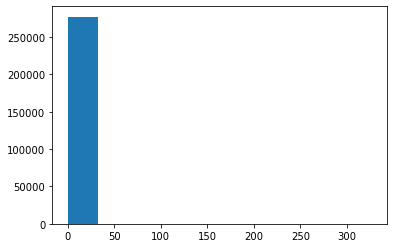

In [265]:
plt.hist(df["article_id"])

In [165]:
london_transaction.to_csv("IntermediateData/london_transaction0618.csv")

In [ ]:
### load the previous file 
data_with_locationNew = pd.read_csv("data_with_location_new.csv")

In [ ]:
data_with_locationNew.columns